[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/112_sd_scratch_1/112_sd_scratch_1.ipynb)

# Stable Diffusion desde cero - Parte 1

El campo de la Inteligencia Artificial Generative (*GenAI*) está más de moda que nunca, con resultados tan impresionantes como los que están proporcionando [ChatGPT](https://chat.openai.com/chat) en la generación de texto o [DALL-E](https://openai.com/dall-e-2/) en la generación de imágenes. Saber cómo funcionan estos modelos es importante si no queremos quedarnos al márgen de la innovación y convertirnos en simples consumidores de tecnología (con el peligro que ello conlleva si tenemos en cuenta la desinformación que pueden generar estos sistemas). Así pues, con este post arrancamos una nueva serie en las que aprenderemos sobre generación de imágenes implementando [Stable Diffusion](https://es.wikipedia.org/wiki/Stable_Diffusion) desde cero. !Vamos allá!

> En estos posts no vamos a entrar en muchos detalles matemáticos ni en el porqué de si hacemos las cosas como os voy a explicar funcionan y si no, no. Para ello os dejo al final una lista de recursos muy interesantes con los que os podréis meter de lleno en el tema con todas las ecuaciones y demostraciones matemáticas que queráis :)

## Generando imágenes

Nuestro principal objetivo es el de generar imágenes convincentes de manera estocástica, a partir de ruido. En este primer post nos centramos simplemente en la parte de generación de imágenes, más adelante veremos cómo poder "guiar" este proceso mediante texto para generar imágenes con un contenido concreto y otras aplicaciones interesantes de los modelos de difusión.

Para empezar, usaremos nuestro querido datasets MNIST ya que su tamaño es simplicidad es perfecto para poder hacer pruebas y experimentar de manera rápida.

In [280]:
from sklearn.datasets import fetch_openml
import numpy as np


mnist = fetch_openml('mnist_784', version=1)
# importante que las imágenes estén en el rango -1, 1
X, y = 2. * (mnist["data"].values.astype(float).reshape(-1, 28, 28) / 255.) - 1., mnist["target"].values.astype(int)
np.savez_compressed("mnist.npz", X=X, y=y)

# la descarga puede tardar un rato, así que te recomiendo comentar las líneas anteriores después 
# de ejecutarlas la primera vez y descomentar las siguientes para cargar los datos desde el disco

# X, y = np.load("mnist.npz")["X"], np.load("mnist.npz")["y"]

X.shape, y.shape

((70000, 28, 28), (70000,))

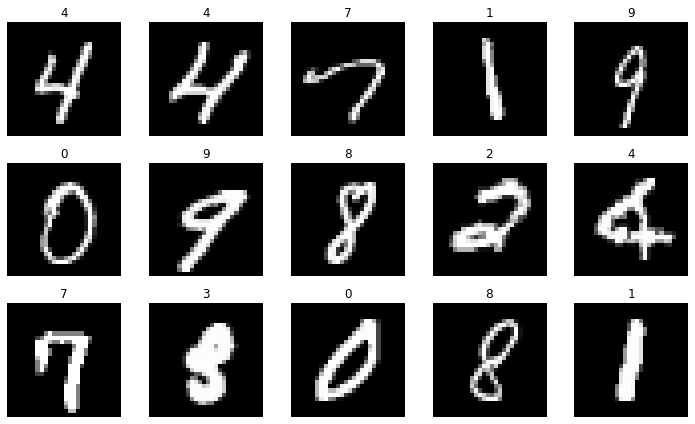

In [282]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import random 

r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X)-1)
        plt.imshow(X[ix], cmap='gray')
        plt.axis("off")
        plt.title(y[ix])
plt.tight_layout()
plt.show()

La siguiente imagen ilustra nuestro objetivo: a la izquierda una imagen con ruido, y a la derecha un dígito extraído del dataset.

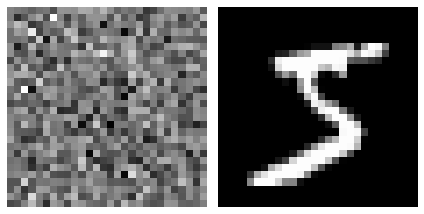

In [283]:
import torch 

fig = plt.figure()
ax = plt.subplot(1, 2, 1)
noise = torch.randn(28, 28) # ruido 
ax.imshow(noise, cmap='gray')
ax.axis('off')
ax = plt.subplot(1, 2, 2)
sample = torch.from_numpy(X[0])
ax.imshow(sample, cmap='gray')
ax.axis('off')
plt.tight_layout()
plt.show()

¿Cómo podemos entrenar un modelo que sea capaz de recibir a la entrada algo como lo de la izquierda y generar algo como lo de la derecha? Para ello, la idea fundamental de los modelos de difusión se basa en entrenar un modelo que sea capaz de predecir el ruido en una imagen. Si somos capaces de resolver esta tarea podremos restar a la imagen de la entrada el ruido predicho por el modelo obteniendo así una imagen realista. 

Durante el entrenamiento generaremos versiones ruidosas de nuestras muestras y entrenaremos el modelo a predecir el ruido añadido.

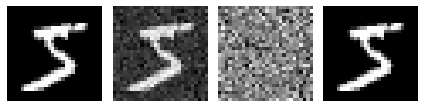

In [285]:
noise = torch.randn(28, 28) * 0.2 # ruido

fig = plt.figure()
ax = plt.subplot(1, 4, 1)
ax.imshow(sample, cmap='gray') # la muestra
ax.axis('off')
ax = plt.subplot(1, 4, 2)
x = sample + noise
ax.imshow(x, cmap='gray') # la muestra con ruido
ax.axis('off')
ax = plt.subplot(1, 4, 3)
ax.imshow(noise, cmap='gray') # el ruido añadido
ax.axis('off')
ax = plt.subplot(1, 4, 4)
ax.imshow(x - noise, cmap='gray') # restamos el ruido para obtener la muestra original
ax.axis('off')
plt.tight_layout()
plt.show()

## Añadiendo ruido al dataset

Si bien la idea es simple, para que funcione tenemos que añadir el ruido a nuestras imágenes de una manera concreta. En el caso de Stable Diffusion, basado en [este paper](https://arxiv.org/abs/2112.10752), se añade ruido de manera progresiva asegurándonos que, al final del proceso, la imagen equivaldrá a ruido gaussiano (que es al final lo que usaremos para alimentar al modelo una vez entrenado para generar imágenes nuevas). A la hora de generar imágenes en fase de inferencia, iremos restando el ruido predicho por el modelo poco a poco hasta obtener el resultado final.

$$
q(x_t|x_{t-1}) = N(x_t;\sqrt{1 - \beta_t} x_{t-1}, \beta_t I)
$$

La manera en la que introducimos ruido se conoce como el *`Noise Scheduler`*, y es uno de los hiperparámetros que diferencia a los diferentes modelos basados en difusión entre sí.

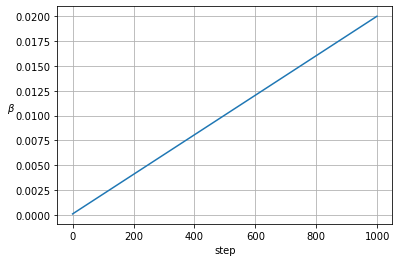

In [101]:
def noise_scheduler(start=1e-4, end=0.02, steps=1000):
	return torch.linspace(start, end, steps)

betas = noise_scheduler()

plt.plot(betas)
plt.xlabel('step')
plt.ylabel('$\\beta$', rotation=0)
plt.grid()
plt.show()

Para cada valor del `step`, $t$, añadiremos un nivel de ruido a la imagen generada en el `step` anterior. La form en la que crece $\beta_t$ puede afectar al resultado, formulaciones alternativas consisten en el uso de un crecimiento siguiendo una función coseno o sigmoide en vez de lineal. ¡Te animo a probarlas en tus experimentos!

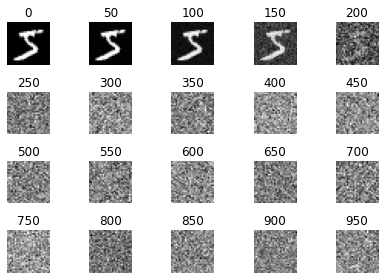

In [102]:
fig = plt.figure()
rs, cs = 4, 5
x = sample
i = 0
for t in range(1000):
	x = torch.randn(28, 28) * betas[t] + x * torch.sqrt(1. - torch.sqrt(betas[t]))
	if t % 50 == 0:
		i += 1
		ax = plt.subplot(rs, cs, i)
		ax.imshow(x, cmap='gray')
		ax.axis('off')
		ax.set_title(t)
plt.tight_layout()
plt.show()

# El Modelo

Como hemos visto anteriormente, el modelo se encargará de predecir el ruido que se ha añadido a la imagen de entrada. En principio podríamos usar cualquier arquitectura de red neuronal que sea capaz de resolver esta tarea. En el caso de Stable Diffusion, la solución adpotada es la de la red conocida como [UNet](https://arxiv.org/abs/1505.04597). 

> En este post no entraremos en detalles acerca de este modelo, ya que lo hemos visto en detalle en posts anteriores. [Aquí](https://juansensio.com/blog/050_cv_segmentacion) tienes un ejemplo de implementación de UNet en PyTorch.

Además, para que el modelo sea capaz de distinguir el `step` en el que nos encontramos añadiremos esta información mediante una capa de `embedding`.

In [240]:
from unet import UNet
import math
import torch

class SinusoidalPositionEmbeddings(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()
        half_dim = dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim) * -embeddings)
        self.register_buffer('embeddings', embeddings)

    def forward(self, time):
        embeddings = time[:, None] * self.embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class DiffusionModel(torch.nn.Module):
    def __init__(self, t_dim=32):
        super().__init__()
        self.time_embed = SinusoidalPositionEmbeddings(t_dim)
        self.unet = UNet(in_ch=1 + t_dim, n_classes=1)

    def forward(self, x, t):
        B, C, H, W = x.shape
        t = self.time_embed(t)
        t = t[:, :, None, None].repeat(1, 1, H, W)
        x = torch.cat((x, t), dim=1)
        return self.unet(x)

model = DiffusionModel()
output = model(torch.randn(10, 1, 28, 28), torch.randint(0, 1000, (10,)))
output.shape

torch.Size([10, 1, 28, 28])

Durante el entrenamiento, alimentaremos a nuestro modelo con un batch de imágenes perturbadas por ruido. Para ello escogeremos de manera aleatoria un valor del `step` para nuestro `noise scheduler` y añadiremos el ruido correspondiente como hemos visto antes. Sin embargo, iterar para cada muestra hasta conseguir el resultado deseado puede resultar costoso, especialmente para valores de `step` altos. Para ello usamos una formulación equivalente pero que nos permite calcular el ruido de manera más eficiente en un solo paso.

$$
q(x_t|x_{0}) = N(x_t;\sqrt{\hat{\alpha_t}} x_{0}, \sqrt{1-\hat{\alpha_t}}I)
$$

donde $\hat{\alpha_t}$ son valores pre-calculados a partir de $\beta_t$.

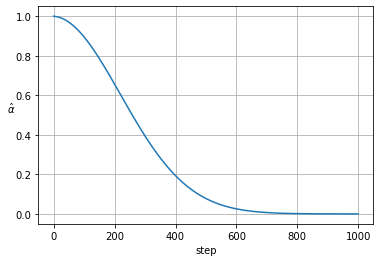

In [241]:
def noise_scheduler(start=1e-4, end=0.02, steps=1000):
	betas = torch.linspace(start, end, steps)
	alphas = 1. - betas
	alphas_hat = torch.cumprod(alphas, axis=0)
	return betas, alphas, alphas_hat

_, _, alphas_hat = noise_scheduler()

plt.plot(alphas_hat)
plt.xlabel('step')
plt.ylabel('$\\hat{\\alpha}$', rotation=0)
plt.grid()
plt.show()

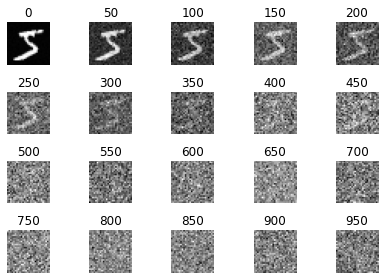

In [242]:
fig = plt.figure()
rs, cs = 4, 5
for i in range(rs*cs):
	ax = plt.subplot(rs, cs, i+1)
	j = 50*i
	x = torch.randn(28, 28) * torch.sqrt(1 - alphas_hat[j]) + sample * torch.sqrt(alphas_hat[j])
	ax.imshow(x, cmap='gray')
	ax.axis('off')
	ax.set_title(j)
plt.tight_layout()
plt.show()

## Entrenamiento

Ahora ya podemos definir nuestro `Dataset` para entrenar el modelo, el cual para cada muestra sampleará un valor del `step` de una distribución uniforme para añadir un nivel de ruido determinado en función del `noise scheduler`.

In [287]:
import numpy as np 

class Dataset(torch.utils.data.Dataset):
	def __init__(self, X, T=1000):
		self.X = X
		self.T = T
		self.betas, self.alphas, self.alphas_hat = noise_scheduler(steps=T)

	def __len__(self):
		return len(self.X)

	def __getitem__(self, ix):
		im = torch.from_numpy(self.X[ix]) # imagen original
		t = torch.randint(0, self.T, (1,))
		noise = torch.randn_like(im) # ruido
		x = noise * torch.sqrt(1 - self.alphas_hat[t]) + im * torch.sqrt(self.alphas_hat[t]) # imagen con ruido
		return x.unsqueeze(0).float(), noise.unsqueeze(0).float(), t

Para empezar y asegurarnos que todo funciona correctamente, vamos a intentar hacer el fit de un solo batch de imágenes, correspondientes al mismo dígito.

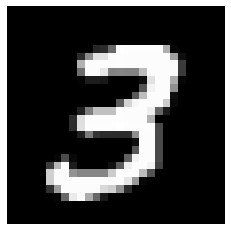

In [288]:
ds = Dataset(X[y == 3]) # usamos solo los 3s

plt.imshow(ds.X[0], cmap='gray')
plt.axis('off')
plt.show()

In [289]:
import tqdm 

EPOCHS = 1000
BATCH_SIZE = 64

ds = Dataset(X[y == 3]) # usamos solo los 3s
dl = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False)
model = DiffusionModel().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
pb = tqdm.tqdm(range(1, EPOCHS+1))
for epoch in pb:
	losses = []
	for im, noise, t in dl:
		im, noise, t = im.cuda(), noise.cuda(), t.cuda().squeeze(-1)
		output = model(im, t)
		loss = torch.nn.functional.mse_loss(output, noise)
		loss.backward()
		optimizer.step()
		optimizer.zero_grad()
		losses.append(loss.item())
		break
	pb.set_description(f'Epoch {epoch}/{EPOCHS} loss {np.mean(losses):.5f}')

Epoch 1000/1000 loss 0.02551: 100%|██████████| 1000/1000 [00:14<00:00, 67.96it/s]


Y ahora podemos generar nuevas imágenes a partir de ruido.

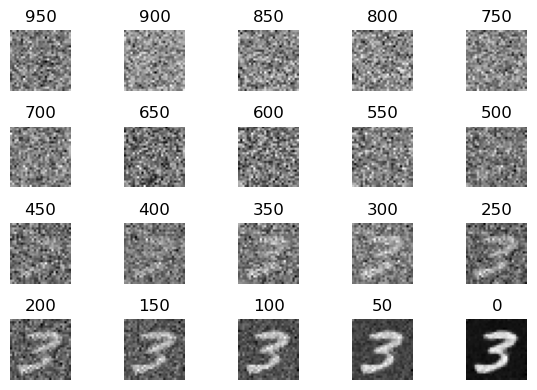

In [297]:
def sample():
	model.eval()
	x = torch.randn(1, 1, 28, 28).cuda() 
	r, c = 4, 5
	fig = plt.figure(dpi=100)
	i = 0
	for t in reversed(range(ds.T)):
		with torch.no_grad():
			output = model(x, torch.tensor([t]).cuda())
		if t > 0:
			noise = torch.randn_like(x)
		else:
			noise = torch.zeros_like(x)
		# algoritmo para restar el ruido de manera progresiva propuesto en el paper
		x = 1. / torch.sqrt(ds.alphas[t]) * (x - ((1. - ds.alphas[t])/(torch.sqrt(1. - ds.alphas_hat[t]))) * output) + noise * torch.sqrt(ds.betas[t])
		# esta aproximación también funciona (pero peor)
		# x = x - output*0.1
		if t % 50 == 0:
			i += 1
			ax = plt.subplot(r, c, i)
			ax.imshow(x[0][0].cpu().numpy(), cmap='gray')
			ax.axis("off")
			ax.set_title(t)
	plt.tight_layout()
	plt.show()

sample()

Como puedes ver el proceso de generación de imágenes consiste en ir restando el ruido predicho por el modelo poco a poco hasta obtener el resultado final, utilizando el mismo `noise scheduler` pero a la inversa.

Ahora ya podemos entrenar nuestro modelo con el dataset entero para generar imágenes de MNIST realistas.

In [302]:
import tqdm

EPOCHS = 10
BATCH_SIZE = 32

ds = Dataset(X) # usamos todo el dataset
dl = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
model = DiffusionModel().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(1, EPOCHS+1):
	losses = []
	pb = tqdm.tqdm(dl)
	for im, noise, t in pb:
		im, noise, t = im.cuda(), noise.cuda(), t.cuda().squeeze(-1)
		output = model(im, t)
		loss = torch.nn.functional.mse_loss(output, noise)
		loss.backward()
		optimizer.step()
		optimizer.zero_grad()
		losses.append(loss.item())
		pb.set_description(f'Epoch {epoch}/{EPOCHS} loss {np.mean(losses):.5f}')

Epoch 10/10 loss 0.02786: 100%|██████████| 2188/2188 [00:23<00:00, 91.63it/s]


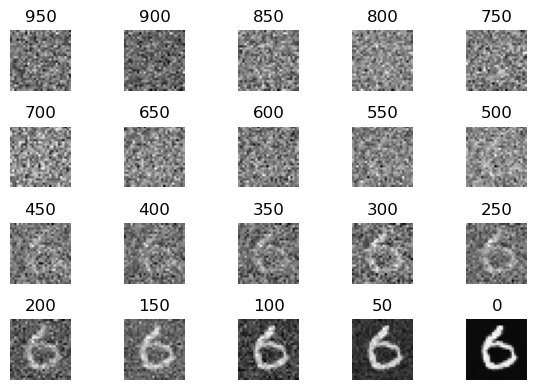

In [307]:
sample()

Obviamente, cuanto más entrenes el modelo mejores resultados podrás esperar. El siguiente código carga un modelo entrenado durante 30 epochs (puedes ver el código [aquí](https://github.com/juansensio/blog/blob/master/112_sd_scratch_1/train.py)).

In [320]:
model = DiffusionModel()
model.load_state_dict(torch.load("model_100.ckpt"))
model.cuda();

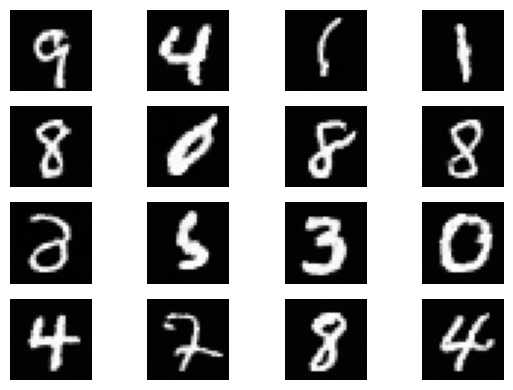

In [321]:
model.eval()
x = torch.randn(1, 1, 28, 28).cuda() 
r, c = 4, 4
fig = plt.figure(dpi=100)
for i in range(r*c):
	for t in reversed(range(ds.T)):
		with torch.no_grad():
			output = model(x, torch.tensor([t]).cuda())
		if t > 0:
			noise = torch.randn_like(x)
		else:
			noise = torch.zeros_like(x)
		x = 1. / torch.sqrt(ds.alphas[t]) * (x - ((1. - ds.alphas[t])/(torch.sqrt(1. - ds.alphas_hat[t]))) * output) + noise * torch.sqrt(ds.betas[t])
	ax = plt.subplot(r, c, i + 1)
	ax.imshow(x[0][0].cpu().numpy(), cmap='gray')
	ax.axis("off")
plt.tight_layout()
plt.show()

Bastante convincente, ¿no crees? Sin embargo este método tiene varias limitaciones:

1. Los dígitos generados son aleatorios (entre 0 y 9). Nos gustaría poder "guiar" el proceso de generación para indicarle que dígito queremos generar. Esto lo veremos en futuros posts.
2. El proceso de generación es muy lento, ya que tenemos que iterar por todos los `steps` del `noise scheduler`. Varios papers actuales proponen soluciones a este hecho.
3. Con MNIST todo puede funcionar, ¿pero qué pasa cuando trabajamos con imágenes de mayor resolución? Como veremos usar el proceso explicado en este post será demasiado costoso en términos computacionalmente, y deberemos utilizar `autoencoders` para comprimir las imágenes a una menor resolución y luego trabajar con la UNet a esta resolución.

Si te interesa este campo de la Inteligencia Artificial te recomiendo que estés atento a los próximos posts de esta serie, !se vienen curvas!

## Referencias

Si quieres aprender más sobre este tipo de modelos te dejo algunos enlaces que me han servido para entenderlos mejor y crear este post.

- [https://huggingface.co/blog/stable_diffusion](https://huggingface.co/blog/stable_diffusion) 
- [https://huggingface.co/blog/annotated-diffusion](https://huggingface.co/blog/annotated-diffusion)
- [https://www.youtube.com/watch?v=_7rMfsA24Ls&t=7024](https://www.youtube.com/watch?v=_7rMfsA24Ls&t=7024)
- [https://www.youtube.com/watch?v=a4Yfz2FxXiY&t=31s](https://www.youtube.com/watch?v=a4Yfz2FxXiY&t=31s) 
- [https://www.youtube.com/watch?v=TBCRlnwJtZU](https://www.youtube.com/watch?v=TBCRlnwJtZU)